In [1]:
from imports import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [5]:
timeseries = process_file()
len(timeseries)

154

In [6]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [310]:
lookback=3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

from utils import scale_data

X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)

X_train torch.Size([100, 3, 1]) y_train torch.Size([100, 3, 1])
X_test torch.Size([48, 3, 1]) y_test torch.Size([48, 3, 1])


#### Defining LSTM Model and hyperparameters

In [317]:
from model import LSTMModel

model = LSTMModel(input_size=lookback, num_layers=1, hidden_size=25)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

#### Training

In [318]:
from model import train_model
train_loss, train_rmse = train_model(model, loader, optimizer, loss_fn, n_epochs=700, print_interval=50, seed=42)

Epoch 50/700, Train Loss: 0.2732,  Train RMSE: 0.0528
Epoch 100/700, Train Loss: 0.2497,  Train RMSE: 0.0505
Epoch 150/700, Train Loss: 0.2477,  Train RMSE: 0.0503
Epoch 200/700, Train Loss: 0.2479,  Train RMSE: 0.0503
Epoch 250/700, Train Loss: 0.2490,  Train RMSE: 0.0504
Epoch 300/700, Train Loss: 0.2424,  Train RMSE: 0.0497
Epoch 350/700, Train Loss: 0.2471,  Train RMSE: 0.0502
Epoch 400/700, Train Loss: 0.2463,  Train RMSE: 0.0501
Epoch 450/700, Train Loss: 0.2399,  Train RMSE: 0.0495
Epoch 500/700, Train Loss: 0.2392,  Train RMSE: 0.0494
Epoch 550/700, Train Loss: 0.2435,  Train RMSE: 0.0498
Epoch 600/700, Train Loss: 0.2408,  Train RMSE: 0.0496
Epoch 650/700, Train Loss: 0.2425,  Train RMSE: 0.0497
Epoch 700/700, Train Loss: 0.2429,  Train RMSE: 0.0498


In [319]:
X_train.shape

torch.Size([100, 3, 1])

#### Evaluating on train and test

In [320]:
from model import evaluate_model_last_prediction
train_preds, train_loss, test_loss, train_rmse, test_rmse, test_preds = evaluate_model_last_prediction(model, X_train, y_train, X_test, y_test, scaler_y, loss_fn)

In [321]:
# creo un array concatenando las predicciones
train_preds = np.concatenate([tensor.flatten() for tensor in train_preds])
test_preds = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_preds), len(test_preds)

(100, 48)

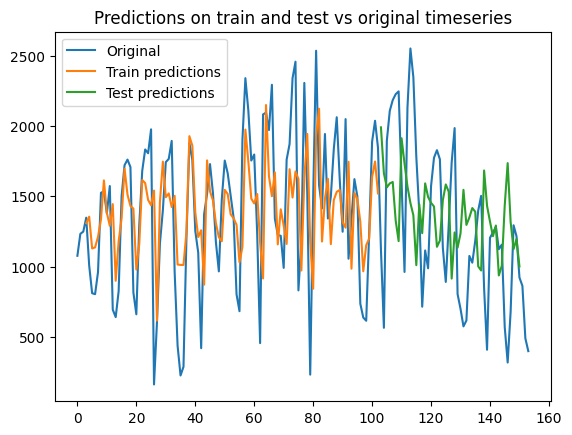

In [322]:
plt.plot(timeseries, label="Original")
plt.plot(range(lookback, lookback + len(train_preds)), train_preds, label="Train predictions")
plt.plot(range(lookback + len(train_preds), lookback + len(train_preds) + len(test_preds)), test_preds, label="Test predictions")
plt.title("Predictions on train and test vs original timeseries")
plt.legend()

In [281]:
test_loss, train_loss

([0.03694296255707741], [0.0240829698741436])

#### Plotting correlation results

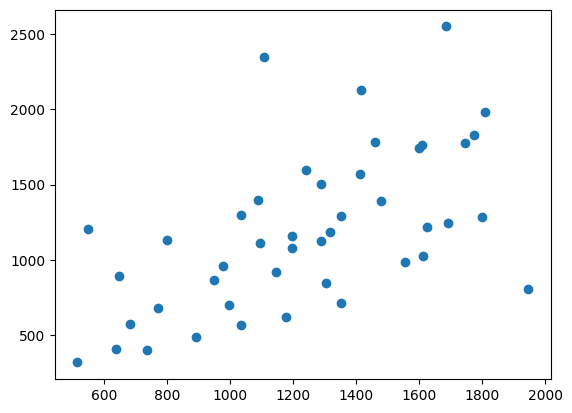

In [305]:
plt.scatter(test_preds, test[lookback:])

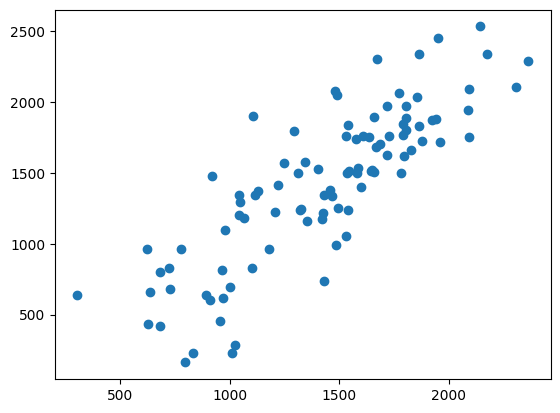

In [306]:
plt.scatter(train_preds, train[lookback:])